# Práctica 4: Compilación y ejecución de programas



## Objetivos

El proceso de traducción de programas de alto nivel a lenguaje máquina es una etapa fundamental en el desarrollo de software, que permite que los programas escritos por los programadores se conviertan en instrucciones que el hardware del computador puede ejecutar directamente. Este proceso, que abarca la compilación, el ensamblado y el enlazado, transforma el código fuente en un ejecutable eficiente y optimizado para la arquitectura específica del sistema. En este boletín de prácticas, exploraremos cada uno de estos pasos, y finalizaremos viendo cómo las instrucciones del programa se ejecutan sobre el hardware haciendo uso del simulador `Ripes.

## El sistema de compilación

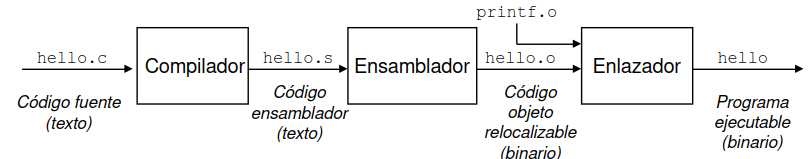

Como muestra la imagen anterior, el sistema de compilación traduce un programa de alto nivel a código máquina ejecutable en varios pasos. Primero, el compilador convierte el código fuente en lenguaje de alto nivel (`hello.c`), el cual es independiente del hardware,  al lenguaje ensamblador, que ya es específico para una arquitectura hardware concreta (x86-64, RISC-V, ARM64, etc.). Luego, el programa ensamblador toma este fichero de código de bajo nivel (`hello.s`), todavía legible por humanos, y lo traduce a código objeto en lenguaje de máquina (`hello.o`), en el cual las instrucciones y datos del programa ya están codificados en binario. Finalmente, el enlazador combina los diferentes ficheros de código objeto (`hello.o`) en los que se organizan generalmente los programas, y resuelve referencias externas a las bibliotecas que use el programa (`printf.o`), para generar un ejecutable completo (`hello`) que puede ser ejecutado por el sistema operativo.

## Traducción de código de alto nivel a lenguaje ensamblador y lenguaje máquina del ISA x86-64


En esta sección veremos cómo se realiza el proceso de compilación para la arquitectura x86-64, por ser el ISA dominante en la mayoría de ordenadores personales y servidores en la actualidad. En esta sección, utilizaremos la aplicación web *Compiler Explorer* para ilustrar de forma sencilla los distintos lenguajes del computador desde la comodidad del navegador. En la siguiente sección, aprenderemos la forma de llevar a cabo el proceso de compilación de manera manual a través del *shell*, utilizando el compilador *GCC* y sus herramientas de asociadas, propias del sistema operativo Linux.

### La aplicación web *Compiler Explorer*.

*Compiler Explorer* es una aplicación web de código abierto disponible en https://godbolt.org, que permite escribir y compilar el código fuente de forma interactiva, todo desde la comodidad del navegador web. Permite elegir entre una amplia variedad de compiladores (GCC, *clang*, etc.) así como generar código para la mayoría de arquitecturas hardware actuales (x86-64, ARM, RISC-V, etc.). Tiene soporte para un gran número de lenguajes de programación, incluyendo lenguajes interpretados como Python, de manera que puedes observar cómo se compila a bytecode para ser ejecutado en la máquina virtual de Python.

Una de sus características más didácticas es que nos indica exactamente a qué instrucciones en el lenguaje ensamblador elegido se traduce cada línea del código fuente, como podemos ver en la siguiente imagen:

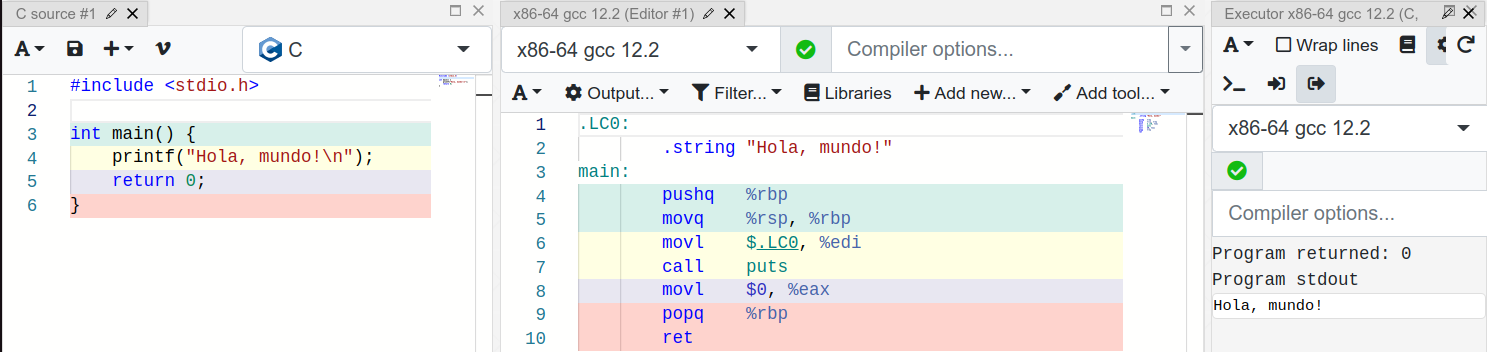

En la imagen anterior, vemos el código fuente en C del típico programa *hello world* junto con su traducción a código ensamblador del ISA x86-64 por parte del compilador GCC, donde mediante colores se nos indica la traducción correspondiente de cada sentencia en C a instrucciones en ensamblador.

El código del programa en C del archiconocido programa *hello world* es el siguiente:
```C
#include <stdio.h>

int main() {
    printf("Hola, mundo!\n");
}
```

Una vez en el navegador, en la página https://godbolt.org, seleccionamos el lenguaje C en el panel izquierdo de código fuente (*source*) y a continuación copiamos el código del programa en C anterior y lo pegamos en dicho panel.
- En el panel derecho podemos elegir el compilador a utilizar, si bien por ahora utilizaremos el compilador por defecto (`gcc` compilando para el ISA x86-64). 
- En el botón *Add new* podemos añadir un nuevo panel del tipo *Executor from this* para observar el resultado de la ejecución del programa.
- En el botón de *Output* del panel del compilador podemos elegir el formato de la salida: en nuestro caso, marcamos las opciones para enlazar a código binario, ejecutar el código, y desmarcamos la opción de usar la sintaxis de Intel.
    * El código máquina de cada instrucción en ensamblador aparece encima, en color gris, en notación hexadecimal, agrupada por bytes (2 cifras hexadecimales)*.
    * Usaremos la sintaxis de AT&T (en vez de Intel), que es la que utiliza el compilador GCC por defecto.

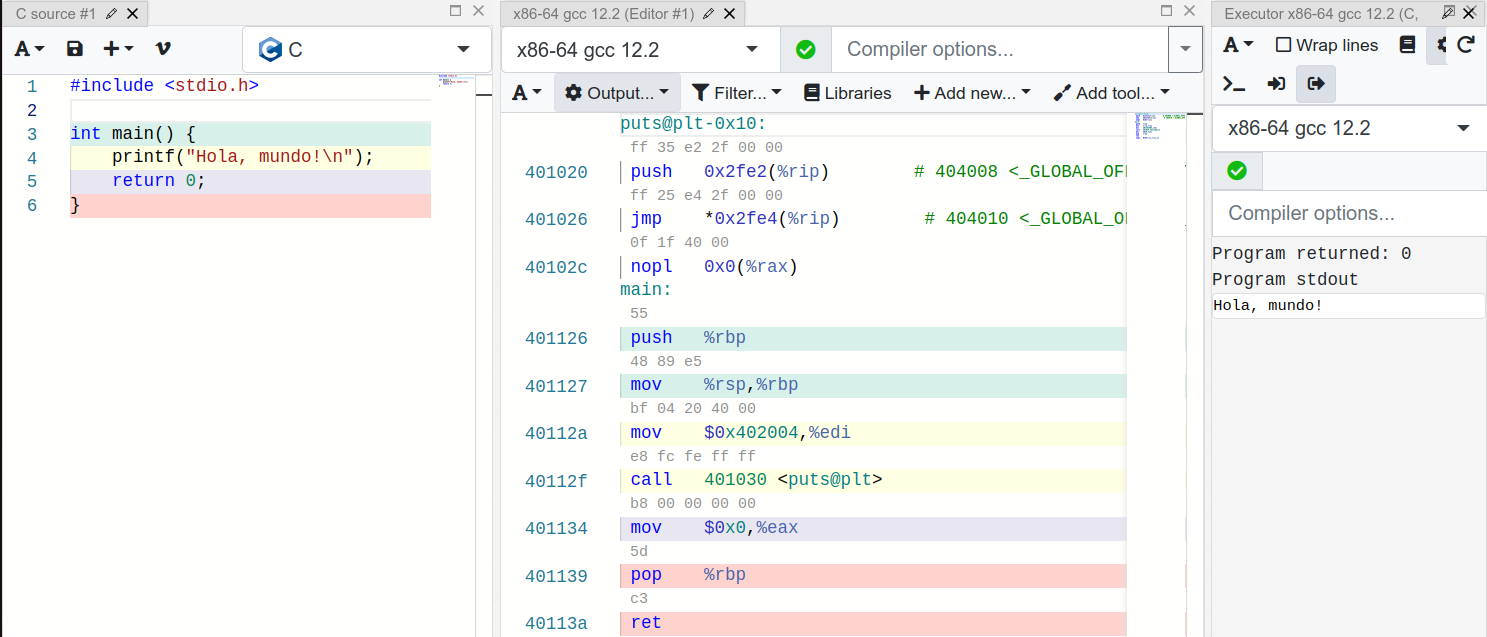

Sin entrar en los detalles de la traducción a ensamblador, vemos que la llamada a la función de la biblioteca de C `printf` para imprimir "Hola, Mundo" se ha traducido en dos instrucciones en ensamblador (ambas en amarillo): el `mov` se utiliza para pasar el argumento a la función en un registro (la cadena a imprimir), mientras que la instrucción `call puts` transfiere la ejecución a la función de la biblioteca de C `puts` (*put string*), que es la que se encarga de imprimir una cadena de caracteres por pantalla.

En la imagen anterior podemos ver algunas características básicas del repertorio de instrucciones del ISA x86-64, entre las que destacan:
- Instrucciones `mov`, para copiar datos de una ubicación a otra (p.ej., de un registro a otro).
- Instrucciones `call` y `ret`, para soportar llamada y regreso de procedimientos.
- Instrucciones explícitas para manejar una región de memoria en forma *pila*, apilando y desapilando (`push`, `pop`).
- La codificación de las instrucciones en lenguaje máquina, vemos que el ISA x86 codifica las instrucciones en **tamaño variable**: hay instrucciones que se codifican en un único byte (p.ej., `0x55` codifica la instrucción `push %rbp`), mientras que otras instrucciones ocupan varios bytes. 

## Proceso de compilación de un programa con GCC en Linux
En el entorno de desarrollo de software sobre Linux, especialmente para el lenguaje C, existen varias herramientas esenciales de compilación que facilitan la conversión de código fuente a ejecutables eficientes y optimizados. Entre las más importantes se encuentran *GCC* (GNU Compiler Collection) y *binutils*. 
- GCC es una colección de compiladores para varios lenguajes de programación, incluyendo C, C++ y otros muchos lenguajes. Se trata de la herramienta principal para compilar programas en Linux, ofreciendo numerosas opciones para optimizar el código, gestionar errores y advertencias, y elegir la generación del código para diferentes arquitecturas de hardware, lo que la hace extremadamente versátil y poderosa.
- Por su parte, también utilizaremos algunas de las herramientas esenciales para el desarrollo de software en sistemas Linux que componen el paquete *binutils*, entre las que destacan el ensamblador `as`, el enlazador `ld`, y también la utilidad `objdump`, que permite analizar, desensamblar, y gestionar archivos objeto y bibliotecas.

Vamos a ver ahora cómo llevar a cabo los diferentes pasos en la jerarquía de traducción en un entorno Linux,
utilizando para ello el compilador GCC. Si bien sus siglas originalmente provienen de GNU C Compiler, hoy en día
GCC es una colección de compiladores con soporte para múltiples lenguajes de programación. GCC es un componente
clave de la cadena de herramientas de GNU y el compilador estándar para la mayoría de los proyectos relacionados
con GNU y el núcleo de Linux.

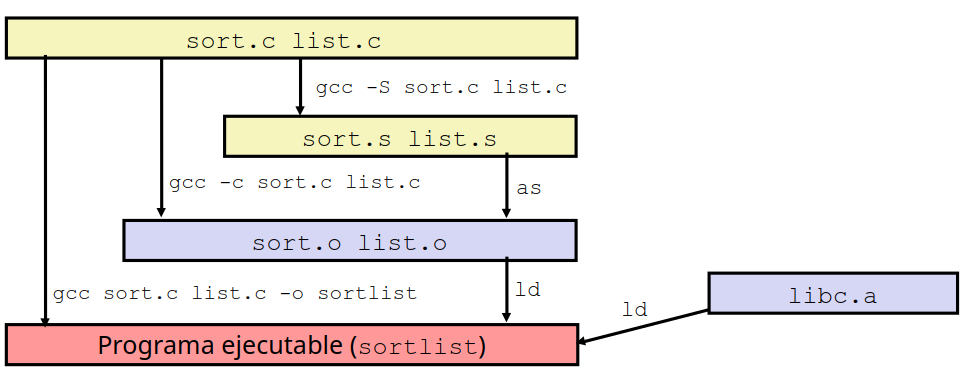

### Compilación directa de código en C a programa ejecutable

Partiremos del fichero de código fuente en C `hola.c`

Al invocar `gcc` pasando como parámetros ficheros de código fuente en C y sin especificar ninguna opción adicional, se llevan a cabo por defecto todas las etapas del proceso de traducción hasta generar un programa ejecutable: **compilación, ensamblado y enlazado**. Este es el comportamiento por defecto que deseamos, ya que es lo que la gran mayoría de veces desea realizar cualquier programador en el proceso de desarrollo de código en un lenguaje compilado como C o C++. 

In [1]:
# Ejecuta esta celda para generar el fichero hola.c
cat <<EOF > hola.c
#include <stdio.h>

int main() {
    printf("Hola, mundo!\n");
}
EOF

In [2]:
cat hola.c

#include <stdio.h>

int main() {
    printf("Hola, mundo!\n");
}


En primer lugar, simplemente compilaremos con `gcc` el programa `hola.c` para obtener un fichero ejecutable llamado `hola`; la opción `-o` (*output*) sirve para indicar el nombre del fichero compilado generado. Utilizamos para ello el siguiente comando:

In [3]:
# Realizamos compilación+ensamblado+enlazado
gcc hola.c -o hola

Comprobamos que, efectivamente, se ha generado un fichero `hola`, con los permisos de ejecución adecuados (`rwx`):

In [4]:
ls -l hola*

-rwxr-xr-x 1 jupyter-KTLvc4ApcX jupyter-KTLvc4ApcX 15960 oct 29 18:30 hola
-rw-r--r-- 1 jupyter-KTLvc4ApcX jupyter-KTLvc4ApcX    65 oct 29 18:29 hola.c


A continuación, simplemente ejecutamos dicho programa:

In [5]:
./hola

Hola, mundo!


### Generación de código ensamblador

Sin embargo, es posible realizar mediante GCC las sucesivas etapas de traducción. Por ejemplo, con la opción `-S` podemos realizar únicamente la etapa de compilación, generando el correspondiente fichero con lenguaje ensamblador del Intel x86-64.

In [6]:
# Con -S, realizamos sólo la compilación a lenguaje ensamblador
gcc hola.c -S

El resultado de la compilación es un nuevo fichero de texto ASCII llamado `hola.s`:

In [7]:
ls -l hola*

-rwxr-xr-x 1 jupyter-KTLvc4ApcX jupyter-KTLvc4ApcX 15960 oct 29 18:30 hola
-rw-r--r-- 1 jupyter-KTLvc4ApcX jupyter-KTLvc4ApcX    65 oct 29 18:29 hola.c
-rw-r--r-- 1 jupyter-KTLvc4ApcX jupyter-KTLvc4ApcX   664 oct 29 18:31 hola.s


In [8]:
# Mostramos las primeras 25 líneas del programa ensamblador generado.
# Eliminamos con "grep -v" algunas directivas generadas, para mayor claridad
head -n25 hola.s | grep -v cfi | grep -v section

	.file	"hola.c"
	.text
.LC0:
	.string	"Hola, mundo!"
	.text
	.globl	main
	.type	main, @function
main:
.LFB0:
	endbr64
	pushq	%rbp
	movq	%rsp, %rbp
	leaq	.LC0(%rip), %rax
	movq	%rax, %rdi
	call	puts@PLT
	movl	$0, %eax
	popq	%rbp
	ret


El contenido más relevante se muestra a continuación. Vemos que el contenido del fichero generado es similar al mostrado, salvo por algunas directivas adicionales (fácilmente identificadas ya que empiezan por el carácter “.”). El compilador genera estas directivas para controlar el proceso de ensamblado; por ejemplo, la directiva  `.text` marca el inicio de la sección de código, en la que se encuentran las instrucciones.

```
        [...]
        .section        .rodata
.LC0:
        .string "Hola, mundo!"

        .text
        [...]
main:
        [...]
        movq    %rax, %rdi
        call    puts@PLT
        [...]
```

### Generación de código objeto

Ahora vamos a ensamblar el fichero en lenguaje ensamblador `hola.s` producido en el paso anterior, con el fin de generar el correspondiente fichero de código objeto `hola.o`. Aunque en realidad el programa ensamblador es independiente (llamado `as`), resulta más cómodo utilizar `gcc` como *front-end* para hacer cualquiera de las etapas de la traducción. Así, con este sencillo comando estamos invocando al ensamblador:

In [9]:
# Ensamblamos el código ensamblador para generar código objeto (en lenguaje máquina)
gcc -c hola.s

In [10]:
# la opción -t de ls ordena por fecha de modificación (más recientes primero)
ls -lt hola*

-rw-r--r-- 1 jupyter-KTLvc4ApcX jupyter-KTLvc4ApcX  1496 oct 29 18:59 hola.o
-rw-r--r-- 1 jupyter-KTLvc4ApcX jupyter-KTLvc4ApcX   664 oct 29 18:31 hola.s
-rwxr-xr-x 1 jupyter-KTLvc4ApcX jupyter-KTLvc4ApcX 15960 oct 29 18:30 hola
-rw-r--r-- 1 jupyter-KTLvc4ApcX jupyter-KTLvc4ApcX    65 oct 29 18:29 hola.c


Como podemos comprobar mostrando su contenido con `cat` que el fichero `hola.o` generado por el comando anterior ya no es un fichero de texto sino un fichero binario: contiene el programa con sus instrucciones y datos codificados en lenguaje máquina. Recordemos que la razón principal por la que no se pueden ejecutar directamente los ficheros de código objeto es que les falta información necesaria para ser un programa completo. Estos archivos objeto contienen código máquina, pero aún no han sido vinculados con otras bibliotecas y otros módulos de código objeto que el programa final puede requerir para funcionar correctamente.

Al contrario que los ficheros de código fuente y código ensamblador, el fichero `hola.o` generado no es un fichero de texto sino un fichero *binario*: si tratamos de mostrar su contenido con `cat`, veremos que efectivamente no está compuesto únicamente por caracteres en codificación UTF8 o ASCII, sino que su contenido son instrucciones y datos en código máquina (1s y 0s).

In [11]:
cat hola.o

                              9      0               k       ,                             B                      �                                      R                     �                                     j                     �       8                             e      @               �                	                                      �       �                          	                      �                                                          �      t                                                 1                     ^       


Para poder interpretar su contenido debemos utilizar una herramienta llamada desensamblador, que realiza la traducción *inversa* desde código máquina a ensamblador, mediante el siguiente comando:

In [12]:
objdump -d hola.o


hola.o:     formato del fichero elf64-x86-64


Desensamblado de la sección .text:

0000000000000000 <main>:
   0:	f3 0f 1e fa          	endbr64 
   4:	55                   	push   %rbp
   5:	48 89 e5             	mov    %rsp,%rbp
   8:	48 8d 05 00 00 00 00 	lea    0x0(%rip),%rax        # f <main+0xf>
   f:	48 89 c7             	mov    %rax,%rdi
  12:	e8 00 00 00 00       	call   17 <main+0x17>
  17:	b8 00 00 00 00       	mov    $0x0,%eax
  1c:	5d                   	pop    %rbp
  1d:	c3                   	ret    


En él podemos comprobar cómo el código correspondiente a la función main del programa se muestra convenientemente formateado en tres columnas, para cada instrucción:
- La primera columna indica su desplazamiento relativo al comienzo del fichero objeto.
- La segunda columna indica su código máquina, mostrado como secuencia de bytes, en hexadecimal.
- La tercera columna muestra el código ensamblador correspondiente a dicha instrucción.

### Enlazado

El programa `ld` del toolkit de GCC se encarga hacer el enlazado de código(s) objeto(s) y biblioteca(s) en un sólo fichero ejecutable. No obstante, el propio `gcc` se puede encargar de llamarlo por nosotros, ya que el comando de enlazado usado internamente es más complicado. Así que, para generar el ejecutable `hola` a partir del anterior fichero objeto `hola.o`, simplemente podemos ejecutar:

In [13]:
# Enlazamos el código objeto con las bibliotecas para generar un ejecutable
gcc hola.o -o hola

In [14]:
ls -lt hola*

-rwxr-xr-x 1 jupyter-KTLvc4ApcX jupyter-KTLvc4ApcX 15960 oct 29 18:59 hola
-rw-r--r-- 1 jupyter-KTLvc4ApcX jupyter-KTLvc4ApcX  1496 oct 29 18:59 hola.o
-rw-r--r-- 1 jupyter-KTLvc4ApcX jupyter-KTLvc4ApcX   664 oct 29 18:31 hola.s
-rw-r--r-- 1 jupyter-KTLvc4ApcX jupyter-KTLvc4ApcX    65 oct 29 18:29 hola.c


El fichero `hola` es un programa ejecutable y por tanto se genera con permisos de ejecución, de ahí que en la mayoría de *shells* modernos su nombre aparezca coloreado en verde. Para ejecutarlo, simplemente tenemos que hacer:

In [15]:
./hola

Hola, mundo!


En posteriores boletines explicaremos más detalladamente la razón por la que es necesario anteponer explícitamente la ruta del directorio actual (`./`) al nombre del fichero (relacionado con el concepto de *PATH*). En caso de no hacerlo, el *shell* no encontrará el programa que queremos ejecutar, ya que el directorio actual no se suele encontrar entre la lista de directorios en los que el *shell* busca los ficheros ejecutables que contienen los programas disponibles:

In [16]:
hola

Orden «hola» no encontrada. Quizá quiso decir:
  la orden «cola» del paquete deb «git-cola (3.12.0-1)»
  la orden «lola» del paquete deb «lola (1.6-1)»
Pruebe con: apt install <nombre del paquete deb>


: 127

### Compilar un programa compuesto por múltiples ficheros de código fuente

In [17]:
# Ejecuta esta celda para generar el fichero saludo.c
cat <<EOF > saludo.c
#include <stdio.h>

void saludar() {
    printf("Hola, mundo!\n");
}
EOF


In [18]:
# Ejecuta esta celda para generar el main.c
cat <<EOF > main.c

// Necesitamos declarar la función aquí, su definición (código) está en otro módulo
void saludar();

int main() {
    saludar();
    return 0;
}
EOF

In [19]:
gcc -c main.c saludo.c

In [20]:
gcc saludo.o main.o -o saludo_modular

In [21]:
./saludo_modular

Hola, mundo!


### Carga en memoria de un programa y ejecución

El último paso en la jerarquía de traducción lo realiza el sistema operativo, mediante un módulo llamado *cargador* (*loader*). El *loader* se encarga de ubicar el programa en memoria, cargar las bibliotecas necesarias y resolver referencias externas, para asegurar que todas las dependencias estén correctamente enlazadas antes de comenzar la ejecución del programa.

Existen herramientas como `gdb`, que nos permiten ejecutar programas dentro de un entorno controlado, paso a paso, observando los valores de las variables, y visualizando tanto el contenido de los registros de la CPU como a las zonas de datos e instrucciones del programa. A este proceso de inspección de un programa en ejecución se le conoce como **depurar** (*debug*), ya que se realiza generalmente en busca de errores y para garantizar el correcto funcionamiento de los programas.

Sin embargo, en el caso de las prácticas de esta asignatura, no llevaremos a cabo la ejecución controlada mediante `gdb` del programa `hola` que hemos compilado anteriormente, por las siguientes razones:
- La relativa complejidad del ISA x86-64 no lo hace aconsejable para enseñar el lenguaje ensamblador en una asignatura introductoria (a pesar de que dicho ISA es el implementado por la mayoría de los procesadores que hoy día conforman los ordenadores personales, incluyendo probablemente el del ordenador en que estás ejecutando este *notebook*, así como los PCs de los laboratorios de la Facultad).
- La interfaz basada en comandos del depurador `gdb`, similar a la del shell, puede resultar poco intuitiva al principio y difícil de utilizar (a pesar de que dicha herramienta es sin dudas el más poderoso aliado de cualquier programador en C/C++).

## Ejecución simulada de un programa compilado para el ISA RISC-V

Por las razones expuestas anteriormente, en lo que resta de boletín nos centraremos en el lenguaje ensamblador del ISA RISC-V. Este repertorio de instrucciones es más sencillo, elegante y resulta más apto que x86-64 para fines educativos.

En esta sección veremos la ejecución de un programa compilado para dicho ISA. Sin embargo, hemos de recordar que el procesador del ordenador que estamos utilizando para ejecutar este *notebook* no implementa el ISA RISC-V (sino probablemente x86-64 o ARM64): eso significa que no es posible ejecutar las instrucciones RISC-V de nuestro programa directamente en el procesador, porque éste *habla otro idioma*.

En su lugar, utilizaremos el **simulador Ripes**, un programa que imita el comportamiento de un procesador con ISA RISC-V, y permite ejecutar programas compilados para RISC-V en cualquier otra plataforma. Además, Ripes permite, al igual que hace `gdb`, ejecutar las instrucciones del programa paso a paso, ver la correspondencia entre código fuente en C y código ensamblador, visualizar el contenido de los registros del procesador simulado y de la memoria simulada, etc. Pero, al contrario que `gdb`, ofrece una interfaz gráfica sencilla e intuitiva, que resulta más adecuada para una asignatura introductoria como ésta.

### El simulador RIPES


En líneas generales, el simulador se divide en cinco vistas o pestañas:
- **Editor**: Es donde podemos escribir el código fuente de nuestro programa, ya sea en C o ensamblador de RISC-V, compilarlo y luego ejecutarlo. A la derecha tenemos un panel llamado *GPR*, que muestra los valores de los registros de propósito general de un procesador que implementa el ISA RV32IM (RISC-V de 32 bits). Al ejecutar el programa veremos cómo cada instrucción ejecutada va leyendo y modificando los valores de los registros (y también los valores en memoria, que se pueden ver en otra pestaña).
- **Procesador**: Muestra su vista del procesador actualmente seleccionado. Ripes soporta diferentes implementaciones del ISA RISC-V (*microarquitecturas*); no entraremos a ver cómo funciona internamente un procesador, así que nos basta con elegir la microarquitectura más sencilla posible (*single-cycle processor*, procesador mono-ciclo).
- **Caché**: Ripes incluye un simulador de caché, que utilizaremos más adelante, en otro boletín de prácticas de esta asignatura.
- **Memoria**: Proporciona una vista de todo el espacio de memoria direccionable por el procesador.
- **Entrada/salida**: No es relevante para este boletín.

En este boletín, nos resultarán útiles principalmente las pestaña del editor y de la memoria.

#### ¿Cómo ejecutar Ripes?

En los PCs del laboratorio de prácticas, siempre en el entorno de Ubuntu, basta con abrir un terminal del shell y ejecutar el comando `Ripes`.


También existe una versión que se puede ejecutar directamente en el navegador [en este enlace](https://ripes.me/), aunque sin la posibilidad de compilar código en C. Esta opción resulta perfectamente válida para observar la ejecución de sencillos programas en ensamblador en el procesador simulado.

### Compilar con la biblioteca estándar de C
Navega a la pestaña del editor y selecciona `input type` a C. Si estás en los PCs del laboratorio de prácticas, Ripes ya está configurado para usar un compilador de C a RISC-V  previamente instalado en el sistema (en otro caso, se producirá un error). Un programa de ejemplo podría ser:
```C
#include <stdio.h>

int main() {
   char buffer[128];
   printf("Escribe algo para ser mostrado:\n");
   fgets(buffer, sizeof(buffer), stdin);
   printf("\nEscribiste: %s", buffer);
   return 0;
}
```
Pulsa el botón del *martillo* (o Ctrl+B) para compilar el programa. Si no se encontraron errores de sintaxis y el programa se compiló correctamente, el ejecutable generado se carga automáticamente en el simulador y es visible en la vista desensamblada a la derecha de la pantalla del editor. A continuación, podemos simular el programa, ejecutándolo completamente (botón `>>`) o avanzando paso a paso (botón `>`).

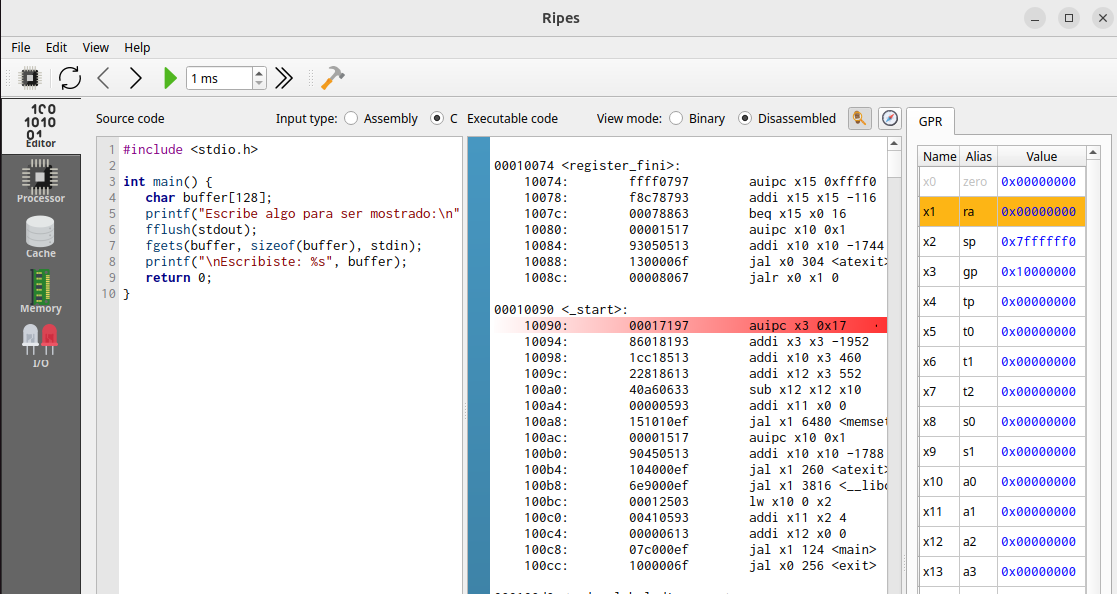

Al compilar un programa en C cualquiera, necesitamos soporte para la biblioteca estándar de C, donde están las funciones que cualquier programa utiliza, tales como imprimir por pantalla (*printf*), leer por teclado (*fgets*), etc.. Como resultado, observa en el panel derecho que se enlaza mucho código de soporte de la biblioteca estándar de C al ejecutable, lo cual a su vez produce un programa que puede ser difícil de navegar si se desea recorrer el programa paso a paso.

Podemos ejecutar el programa completamente y ver que el simulador es plenamente funcional, de forma que a través de la consola simulada podemos interactuar con el programa (ver los mensajes que imprime e introducir otros por teclado).

En el caso de este boletín, en aras de la mayor sencillez, precindiremos de la biblioteca estándar de C, ya que utilizaremos programas muy sencillos que no hacen uso de las funciones de la biblioteca.

### Compilar sin la biblioteca estándar de C
Accediendo al menú *Edit->Settings->Compiler*, **añade la opción `-nostdlib` como argumento del enlazador (*linker arguments*)**. De esta manera, solo las funciones en C escritas por el usuario serán enlazadas en el ejecutable generado. Al hacer esto, el punto de inicio del programa será la primera instrucción en el ejecutable producido. Por lo tanto, asegúrate de colocar manualmente el código de la función de entrada en primer lugar en tu código fuente.

Ahora, vamos a compilar el siguiente código sin hacer uso de ninguna biblioteca. Puedes copiar y pegar en la pestaña del editor de Ripes, y compilar como antes.
```C
void prints(volatile char* ptr);

void hello_ripes() {
    char* str = "Hello, Ripes";
    prints(str);
    return 0;
}

void prints(volatile char* ptr){ // ptr is passed through register a0
    asm("li a7, 4");
    asm("ecall");
}
````

En este caso, vemos que el programa en C se ha traducido a un par de decenas de instrucciones en ensamblador:

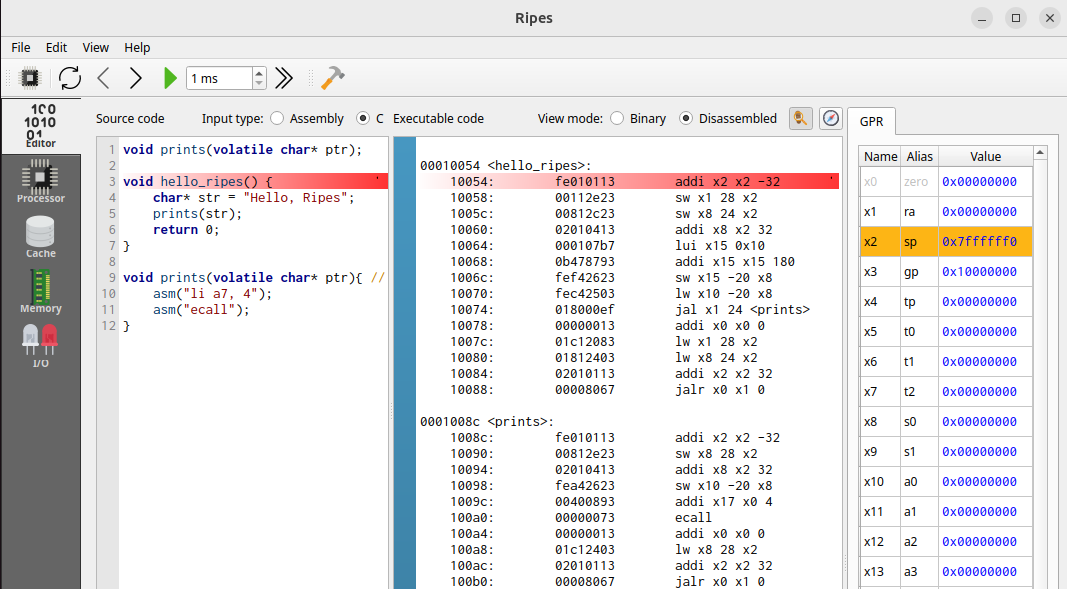

- Primero, prueba a ejecutar el programa completamente y observa cómo se muestra el mensaje "Hello, Ripes" por la consola del simulador.
- Después, ejecútalo de instrucción en instrucción, observando cómo cada instrucción realiza una tarea muy simple y como resultado de su ejecución, van cambiando los valores guardados en los registros del procesador y en la memoria.
    > El conjunto de valores de los registros y la memoria conforman el *estado arquitectural* del programa en un instante dado, y dicho estado va cambiando a cada instrucción ejecutada, hasta completar la tarea dictada por el programador.


### Resumen de instrucciones en RISC-V imprescindibles
Las instrucciones de RISC-V que necesitamos conocer para este boletín son:
- `lw` (*load word*): lee una palabra (4 bytes) de memoria y coloca el valor en un registro del procesador.
- `sw` (*store word*): escribe en memoria el valor que actualmente tiene un registro del procesador (4 bytes).
- `addi` (*add immediate*): suma el valor de registro con un valor constante (pequeño) y escribe el resultado en un registro.
- `li` (*load inmediate*): establece un registro con un valor constante (de hasta 4 bytes). Esta es una *pseudoinstrucción*, ya que puede que sea necesario hacerlo en dos pasos, mediante dos instrucciones que escriban, respectivamente, la parte alta y baja del registro.
- `la` (*load address*): establece un registro con *la dirección de memoria* de una variable dada por su etiqueta.
- `jal` (*jump and link*): salta a otra instrucción (distinta de la siguiente), y guarda la dirección de retorno para poder regresar posteriormente (llamadas a funciones).
- `beq` (*branch if equal*), `bne` (*branch if not equal*): compara dos registros y salta a otra instrucción si se cumple la condición (iguales o distintos, según el tipo de instrucción).

### Tu primer programa en ensamblador RISC-V: Sumar dos constantes pequeñas

Copia el siguiente código a la pestaña del editor de Ripes y ejecuta paso a paso las instrucciones. 

```
    li x5, 8
    li x6, 4
    add x7, x5, x6
```

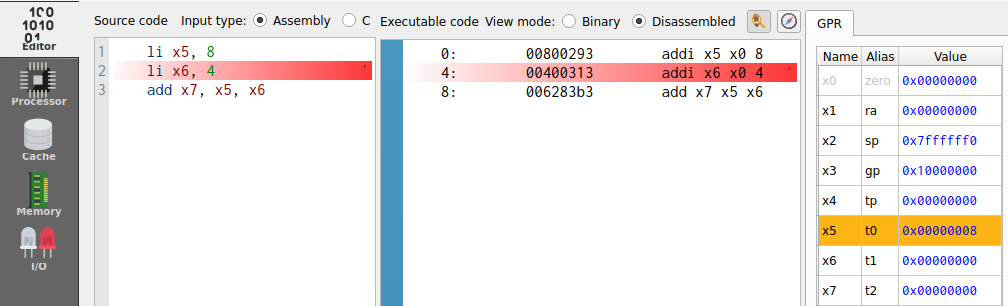

Podemos ver lo siguiente:
- `li` (*load immediate*, cargar constante en registro) en realidad es una *pseudoinstrucción*, ya que es equivalente a usar una instrucción de suma con inmediato (`addi`), usando como operando fuente el registro x0 ($zero), que según el ISA está "cableado" siempre con el valor cero.
- `addi` contiene el valor constante (*inmediato*) como parte de la codificación de la propia instrucción. Podemos ver en la columna que muestra el código máquina de la instrucción (en hexadecimal), que en los 12 bits más significativos de los dos `addi` aparecen, respectivamente, los valores 8 y 4.
- En el punto que se encuentra detenido el programa (segundo `li`), vemos que el registro x5 tiene el valor 8. Este valor fue establecido por la última instrucción ejecutada, de ahí que aparezca resaltado en amarillo. *El valor que tuviese anteriormente guardado el registro se pierde cada vez que se ejecuta una instrucción que utiliza dicho registro como operando destino, es decir, para escribir un valor*.

### Sumar dos variables: accediendo a memoria

El programa anterior no realiza ningún acceso a datos del programa, sino que suma dos valores constantes que están codificados en las propias instrucciones del programa. En este segundo programa, vamos a sumar dos *variables globales*, las cuales se ubican en una zona de la memoria del programa conocida como *segmento de datos*. Copia y pega en Ripes, y ejecuta paso  paso.

```
    .data

var1: .word 256
var2: .word 255

    .text

    la x4, var1			
    lw x5, 0(x4)
    lw x6, 4(x4)
    add x7,x5,x6
```

Si cambiamos a la pestaña *Memory* podremos ver los valores en memoria. Para navegar por la memoria utilizaremos *Go to section*. Si vamos al `.data` (segmento de datos, donde están las variables del programa), veremos que `var1` y `var2` están ubicadas en las direcciones de memoria 0x10000000 y 0x10000004, respectivamente. Ambas variables tienen tamaño 4 bytes (lo cual se indica al ensamblador mediante `.word`) y sus valores iniciales 256 (0x100) y 255 (0xff).

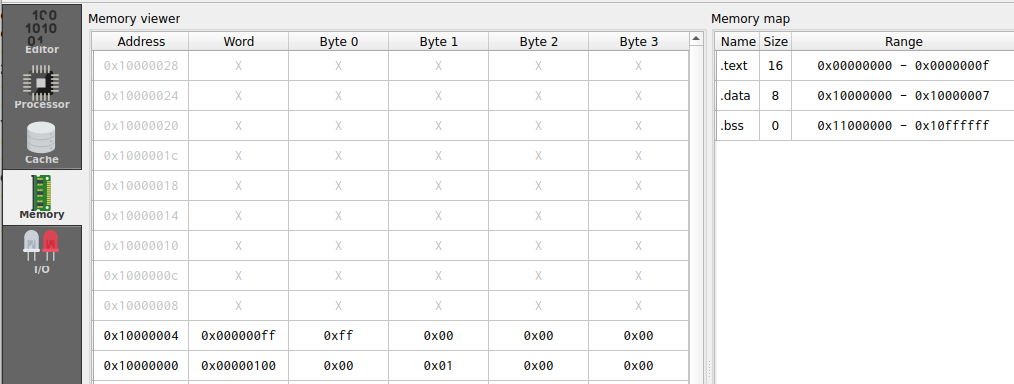

Si ahora regresamos al editor y ejecutamos paso a paso el programa hasta el final, veremos lo siguiente:
- La pseudoinstrucción `la x4, var1` se traduce por dos instrucciones: `auipc` y `addi`. Sin entrar en los detalles, lo relevante es que tras ejecutarse, el registro x4 queda establecido con **la dirección de memoria** donde se ubica la variable `var1` (0x10000000).

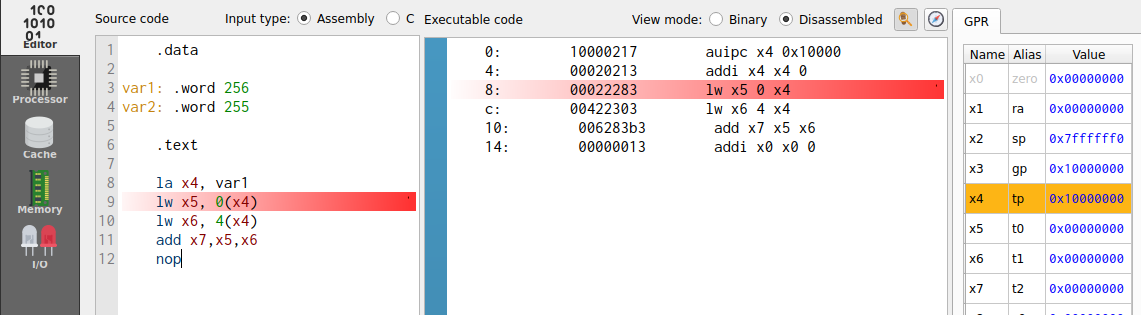

- Tras ejecutar `li`, la primera instrucción `lw` (*load word*, cargar 32 bits de memoria) lee el valor en el registro x4 (0x10000000), que se utiliza como la dirección de memoria de la que se quiere leer. Por tanto, al ejecutar `lw`, el procesador realiza un acceso a memoria, obtiene el valor guardado entre la dirección de memoria 0x10000000 y 0x10000003 (puesto que se leen 4 bytes, 32 bits, una palabra) y finalmente lo escribe en el registro destino, x5. Así pues, tras ejecutar esta instrucción, vemos que x5 pasa a tener el valor 0x100 (256), que era precisamente el valor inicial de `var1`, ubicada en la dirección 0x10000000.

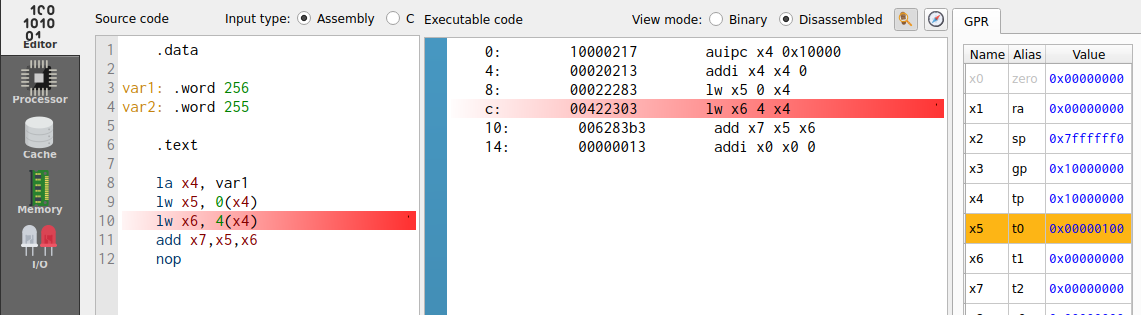

- El segundo *load word* hace lo propio para leer la variable `var1`. Como dicha variable se encuentra en la dirección 0x10000004, la forma de acceder a ella es sumar 4 al valor del registro x4. Esto es lo que significa el número que aparece antes de los paréntesis: `lw x5, 4(x4)` quiere decir *coge el valor de x4, súmale 4 y el resultado será la dirección de memoria que se debe leer; el valor guardado en memoria en dicha dirección se debe copiar al registro x5*.
- Por último, la instrucción `add` suma los valores de los dos registros x4 y x5, y coloca el resultado de la suma en el registro x7 (0x1ff, 511). Cabe aclarar que `nop` es una instrucción que no hace nada (*no operation*), incluida por claridad, para poder detener el programa en la instrucción siguiente al `add` y poder ver que esta modifica x7.

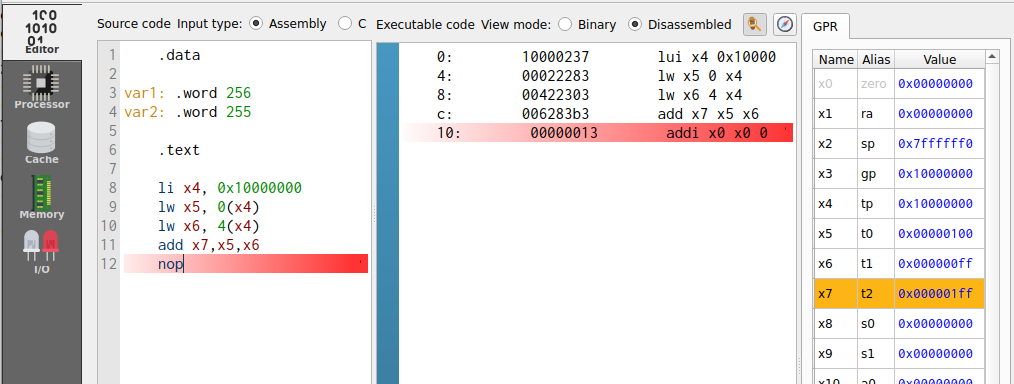

### Comparando valores: `if (var1 != var2)`

Los dos sencillos programas vistos anteriormente tienen un aspecto en común, ambos ejecutan sus instrucciones una tras otra, desde la primera a la última, sin que la secuencia de instrucciones se vea interrumpida en ningún caso. En este caso, vamos a ver cómo las instrucciones de salto condicional como `beq` (*salta si igual*) dan soporte a estructuras condicionales como el `if`.

```
    .data

var1: .word 256
var2: .word 256

    .text

    la x4, var1
    lw x5, 0(x4)
    lw x6, 4(x4)
    li x10, 1   
    beq x5,x6,iguales
    li x10, 0   # Sólo se ejecuta si son distintos
iguales:
    # x10 será 1 si var1 y var2 son distintos, 0 si son iguales
    nop
```

- Ejecuta el programa paso a paso, hasta comprobar que la condición de `beq` se cumple y por tanto, al ejecutar `beq` el programa salta al `nop` del final de programa, sin ejecutar la  instrucción `li x10, 0`. Continúa hasta el final y comprueba que el registro x10 vale 1 al terminar la ejecución del programa.   

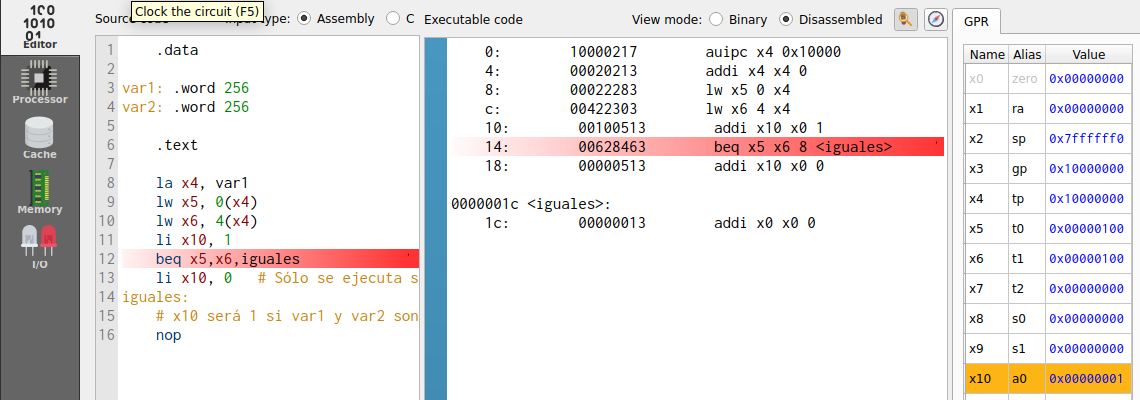

- Repite la ejecución paso a paso, pero antes de llegar a la instrucción `beq`, sustituye manualmente el valor del registro x5 (basta con hacer *doble clic* en el registro) por otro distinto de 0x100 (256). Prosigue la ejecución y comprueba que ahora la condición de `beq` no se cumple, por lo no se salta y el valor final de x10 es 0, establecido por el último `li`.

### Llamadas a procedimientos

Vuelve a copiar el código anterior de `hello_ripes` que hemos utilizado anteriormente, y ejecútalo paso a paso hasta llegar a la instrucción `jal`.

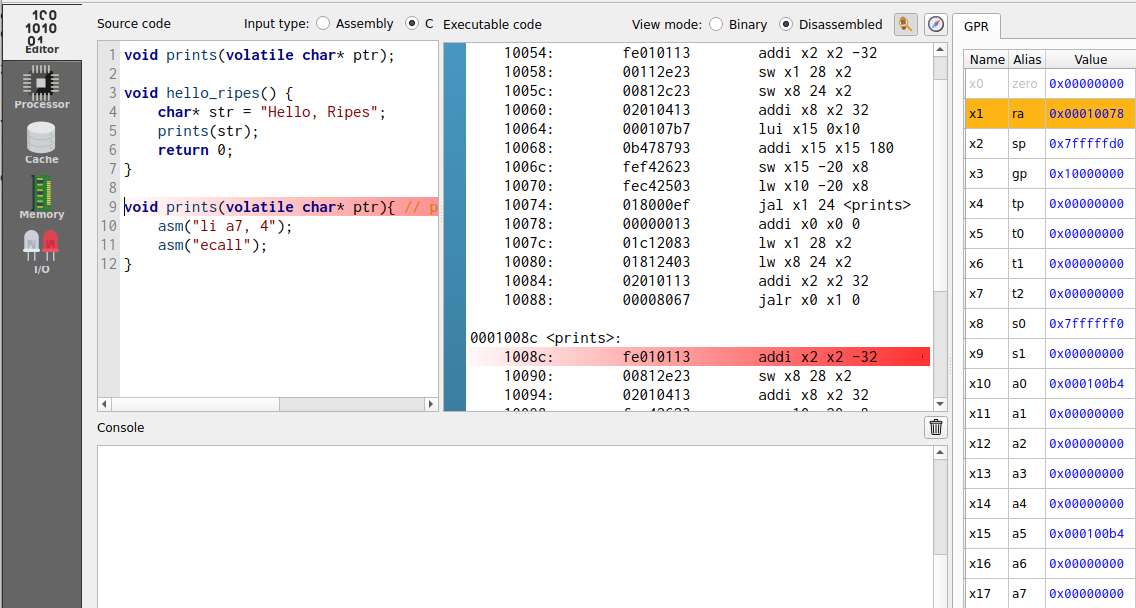

- `jal` (*jump and link*) es una instrucción que se utiliza para *saltar* a ejecutar otra instrucción distinta de la siguiente en secuencia, pero que además guarda la dirección de la instrucción siguiente al propio `jal`, para poder regresar posteriormente a ese punto. En RISC-V, icha *dirección de retorno* se guarda en el registro x1, cuyo alias es `ra`, por *return address*. La dirección de retorno se utilizará posteriormente para regresar de la función `prints` a `hello_ripes`, justo por la instrucción siguiente al `jal` (dirección 0x10078). 
> Este tipo de instrucciones son imprescindibles en cualquier repertorio (ISA), ya que dan soporte a las llamadas a procedimientos y funciones de los programas de alto nivel, que nos permiten estructurar mejor nuestros programas, reutilizar código, etc. En el ISA x86 existe una instrucción parecida que se llama *call*, que vimos en la sección anterior. 

### Acceder a los dispositivos de E/S: interfaz con el sistema operativo

Como normal general, los programas necesitan acceder con cierta frecuencia a los dispositivos de entrada/salida para interactuar con el exterior, ya que es a través de estos dispositivos que pueden recibir datos de los usuarios, almacenar información, mostrar resultados o comunicarse con otros sistemas. Sin embargo, como se verá más adelante en esta asignatura, los programas de usuario no tienen permitido acceder directamente al hardware, porque esto comprometería la seguridad del sistema y lo haría vulnerable: un programa erróneo o malicioso podría realizar acciones que comprometan la integridad y confidencialidad de los datos, modificar o interceptar datos en tránsito, corromper ficheros, sobrecargar un dispositivo, o incluso causar un mal funcionamiento del hardware. Además, el acceso directo podría eludir las políticas de seguridad y los mecanismos de control implementados por el sistema operativo, exponiendo el sistema a vulnerabilidades y potencialmente permitiendo que un atacante tome el control del dispositivo o acceda a información sensible.

Es por esto que el sistema operativo, con cierto soporte por parte del hardware del procesador, restringe el acceso a los dispositivos de E/S. Para llevar a cabo dichos accesos, el sistema operativo ofrece una interfaz de **llamadas al sistema**, que no son sino procedimientos del sistema operativo que proveen de una serie de servicios a los programas. Así, los programas de usuario pueden solicitar algún servicio concreto del sistema operativo realizando una llamada al sistema, de la cual no regresarán hasta que la petición solicitada haya sido completada por el sistema operativo. En RISC-V, la instrucción `ecall` es la que se encarga de realizar una llamada al sistema.


- Siguiendo con el programa anterior, continúa la ejecución hasta parar en la instrucción *anterior* a `ecall`. En este punto, observa el valor del registro x10 (a0), que según el convenio de RISC-V se usa para pasar argumentos en llamadas a procedimientos. Verás que su valor es 0x100b4.
- Ahora, pasa a la pestaña de memoria, elige *Go to register-->a0*, y cambia el *display type* de hexadecimal a ASCII: Verás que el contenido de las direcciones 0x100b4 a la 0x100c0 (incluida) son precisamente los caracteres de la cadena "Hello, Ripes". El compilador ha ubicado la cadena de caracteres `str` a partir de la dirección 0x100b4. Este valor (que no es sino un *puntero* a `str`) es lo que se pasa  como argumento a la función `prints` para imprimir la cadena por pantalla.
  > Las cadenas de caracteres en C siempre están acabadas en un byte con valor 0 (*null terminator*), que marca el fin de la cadena.

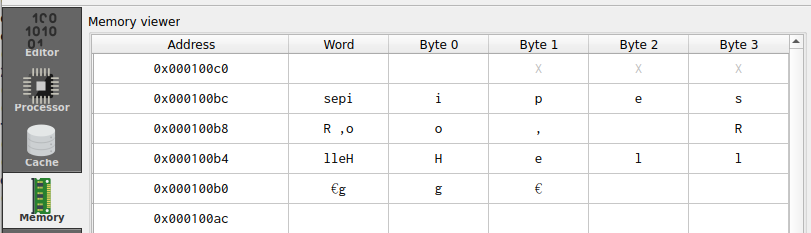

- Regresa al editor y ejecuta una instrucción más hasta llegar a `ecall`. Verás que, *mágicamente*, la cadena aparece por la consola del simulador. Si estuviésemos ejecutando el programa en un procesador real, la ejecución de la instrucción `ecall` de nuestro programa hubiera resultado en que este dejase de ejecutarse, para que pase a hacerlo el código del sistema operativo (las instrucciones que implementan la llamada al sistema *write*).
  > En este caso, al tratarse de un programa simulado que se ejecuta sobre Ripes y no sobre un procesador RISC-V real, `ecall` no está realmente invocando a nuestro sistema operativo Linux, sino que Ripes "simula" también algunas llamadas al sistema comunes, tales como "escribir en fichero", que es la que se está invocando en este caso para imprimir por pantalla.

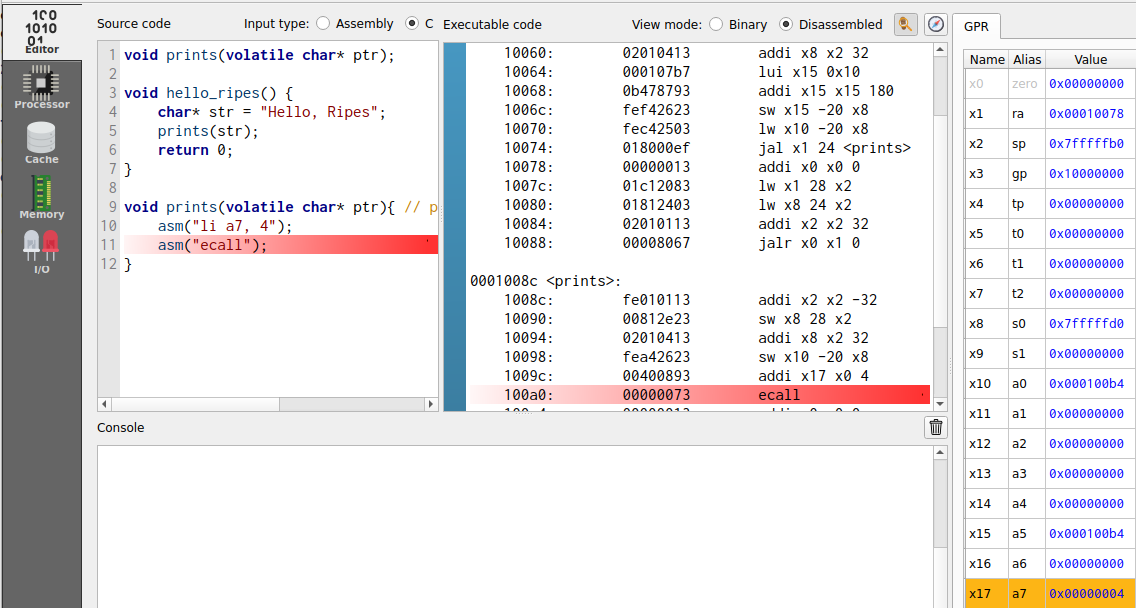

- Por último, en el menú *Help->System calls* podemos ver la lista de llamadas al sistema soportadas por el simulador Ripes. Como vemos en la siguiente imagen, la llamada número 4 (valor que el programa puso en el registro `a7` antes de llamar a `ecall`) corresponde a *PrintString*, que escribe una cadena por la consola, cuya dirección se debe pasar como argumento en el registro `a0` (0x100b4, en el caso de `str`).

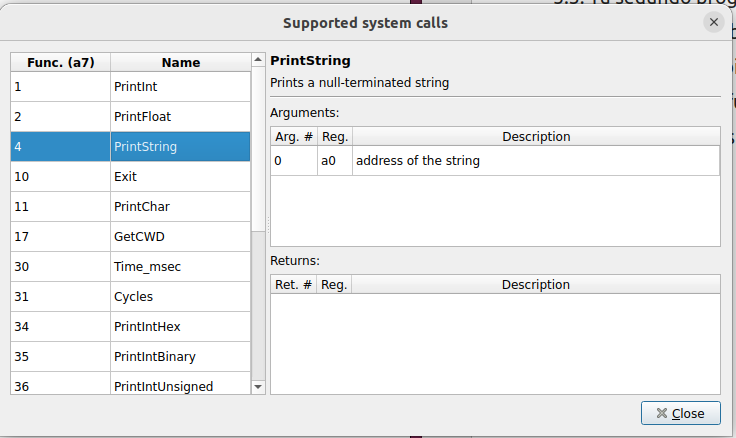